In [44]:
import torch
from torch_geometric.nn import MessagePassing, radius_graph
from molecule_featurizer import MoleculeFeaturizer
from rdkit import Chem
from rdkit.Chem.rdDistGeom import EmbedMolecule
from torch.nn import Embedding, Linear, ModuleList, Sequential
from math import pi as PI
import os
import os.path as osp
import warnings
from math import pi as PI
from typing import Optional

import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ModuleList, Sequential
from torch_scatter import scatter

from torch_geometric.data import Dataset, download_url, extract_zip
from torch_geometric.data.makedirs import makedirs
from torch_geometric.nn import MessagePassing, radius_graph

In [39]:
class ShiftedSoftplus(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x):
        return F.softplus(x) - self.shift

In [54]:
class GaussianSmearing(torch.nn.Module):
    def __init__(self, start=0.0, stop=5.0, num_gaussians=50):
        super().__init__()
        offset = torch.linspace(start, stop, num_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist):
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))

In [3]:
class InteractionBlock(torch.nn.Module):
    def __init__(self, hidden_channels, num_gaussians, num_filters, cutoff):
        super().__init__()
        self.mlp = Sequential(
            Linear(num_gaussians, num_filters),
            ShiftedSoftplus(),
            Linear(num_filters, num_filters),
        )
        self.conv = CFConv(hidden_channels, hidden_channels, num_filters,
                           self.mlp, cutoff)
        self.act = ShiftedSoftplus()
        self.lin = Linear(hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.mlp[0].weight)
        self.mlp[0].bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.mlp[2].weight)
        self.mlp[2].bias.data.fill_(0)
        self.conv.reset_parameters()
        torch.nn.init.xavier_uniform_(self.lin.weight)
        self.lin.bias.data.fill_(0)

    def forward(self, x, edge_index, edge_weight, edge_attr):
        x = self.conv(x, edge_index, edge_weight, edge_attr)
        x = self.act(x)
        x = self.lin(x)
        return x

In [46]:
class CFConv(MessagePassing):
    def __init__(self, in_channels, out_channels, num_filters, nn, cutoff):
        super().__init__(aggr='add')
        self.lin1 = Linear(in_channels, num_filters, bias=False)
        self.lin2 = Linear(num_filters, out_channels)
        self.nn = nn
        self.cutoff = cutoff

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)

    def forward(self, x, edge_index, edge_weight, edge_attr):
        C = 0.5 * (torch.cos(edge_weight * PI / self.cutoff) + 1.0) # non-linear scaling to 1 to 0 coefficient for 0 to cutoff distance
        W = self.nn(edge_attr) * C.view(-1, 1) # W

        x = self.lin1(x)
        x = self.propagate(edge_index, x=x, W=W)
        x = self.lin2(x)
        return x

    def message(self, x_j, W):
        import pdb;pdb.set_trace()
        return x_j * W

In [14]:
mf = MoleculeFeaturizer()
mol = Chem.MolFromSmiles('CC(=O)NC1=CC=C(C=C1)O')
EmbedMolecule(mol)
data = mf.featurize_mol(mol)

RDKit WARNING: [15:39:25] Molecule does not have explicit Hs. Consider calling AddHs()
[15:39:25] Molecule does not have explicit Hs. Consider calling AddHs()


In [61]:
MolConfViewer(widget_size=(500,500)).view(mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:', max=0), Output()), _dom_classes=('w…

BoundedIntText(value=0, description='Conformer ID:', max=0)

In [37]:
z = data[0].x.squeeze().long()
pos = data[0].pos
batch = None
cutoff = 10
max_num_neighbors = 32
num_gaussians = 50
num_filters = 128
hidden_channels = 128
num_interactions = 6

In [47]:
assert z.dim() == 1 and z.dtype == torch.long
batch = torch.zeros_like(z) if batch is None else batch

embedding = Embedding(100, hidden_channels)
h = embedding(z)

edge_index = radius_graph(pos, r=cutoff, batch=batch,
                          max_num_neighbors=max_num_neighbors)
row, col = edge_index
edge_weight = (pos[row] - pos[col]).norm(dim=-1)

distance_expansion = GaussianSmearing(0.0, cutoff, num_gaussians)
edge_attr = distance_expansion(edge_weight)

interactions = ModuleList()
for _ in range(num_interactions):
    block = InteractionBlock(hidden_channels, num_gaussians,
                                num_filters, cutoff)
    interactions.append(block)
    
for interaction in interactions:
    h = h + interaction(h, edge_index, edge_weight, edge_attr)

> /tmp/ipykernel_49238/1353802608.py(27)message()
     23         return x
     24 
     25     def message(self, x_j, W):
     26         import pdb;pdb.set_trace()
---> 27         return x_j * W



ipdb>  x_j


tensor([[-0.9246,  0.5265,  1.4103,  ..., -1.6762, -0.1755, -0.2186],
        [ 0.0726, -0.1935,  0.6384,  ..., -0.0172,  1.3915,  1.3400],
        [ 0.3068, -0.0174,  1.1401,  ..., -1.8795,  1.2532,  0.7094],
        ...,
        [ 0.3068, -0.0174,  1.1401,  ..., -1.8795,  1.2532,  0.7094],
        [-0.9246,  0.5265,  1.4103,  ..., -1.6762, -0.1755, -0.2186],
        [-0.9246,  0.5265,  1.4103,  ..., -1.6762, -0.1755, -0.2186]],
       grad_fn=<IndexSelectBackward>)


ipdb>  x_j.shape


torch.Size([110, 128])


ipdb>  W.shape


torch.Size([110, 128])


ipdb>  n


--Return--
tensor([[ 1.3...MulBackward0>)
> /tmp/ipykernel_49238/1353802608.py(27)message()
     23         return x
     24 
     25     def message(self, x_j, W):
     26         import pdb;pdb.set_trace()
---> 27         return x_j * W



ipdb>  exit


BdbQuit: 

In [38]:
gs.coeff

-12.004999177113218

In [55]:
gs = GaussianSmearing(stop=10)

In [48]:
dist = torch.linspace(1, 5, 10)

In [47]:
C = 0.5 * (torch.cos(dist * PI / 10) + 1.0)

In [48]:
C

tensor([1.0000, 0.9855, 0.9427, 0.8743, 0.7840, 0.6773, 0.5603, 0.4397, 0.3227,
        0.2160, 0.1257, 0.0573, 0.0145, 0.0000])

In [57]:
rbf = gs(dist)

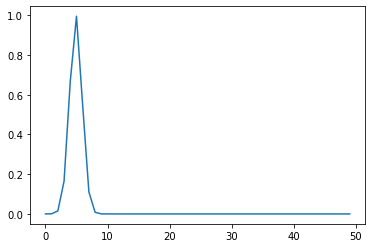

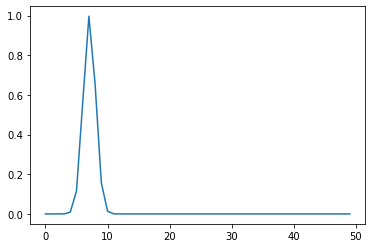

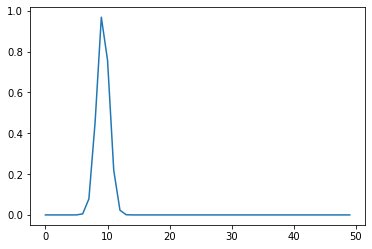

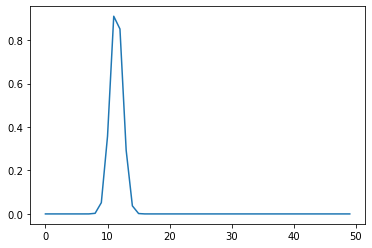

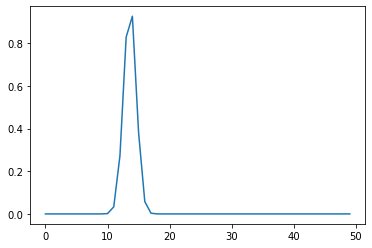

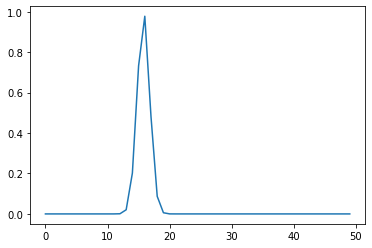

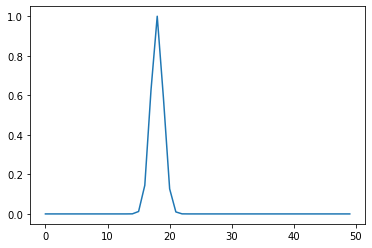

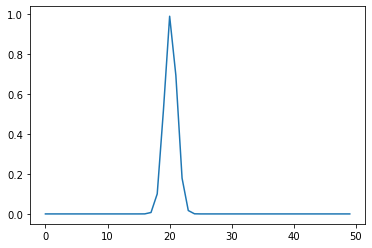

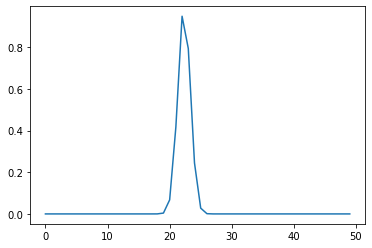

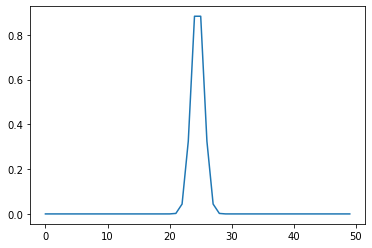

In [59]:
import matplotlib.pyplot as plt
for i, d in enumerate(rbf) :
    plt.plot(d, label=i)
    plt.show()